## Angle vs. Time Plot of Pendulums

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

#### Load angles from file

The experiment is conducted with pendulums modeled with a lock hanging on a thin string. Experiment is repeated with different rest lengths of the string. However, the actual length of the pendulum may be longer due to the stretch of the string and the size of the lock.

A one-minute video of the pendulum is recorded and the motion of the pendulum is tracked using OpenCV. The CSV files with the time and the UV coordinates of the pendulum relative to a rectangular frame is stored under `csv/uvt-{length}.csv`. The width of the frame is 0.98m and the height of the frame is 1.36m. One end of the string is tied on the middle of the top of the frame.

In [2]:
LENGTHS = [20, 30, 40, 50, 60, 70, 80]
WIDTH, HEIGHT = 0.98, 1.36

data = {}
for length in LENGTHS:
    # load data from file
    with open(f"csv/uvt-{length}.csv", 'r') as fp:
        lines = fp.read().strip().replace('\r', '').split('\n')
        content = [list(map(float, line.split(','))) for line in lines]
        content = np.array(content, dtype=np.float64)

    # get length and angle
    t = content[:, 0]
    x = WIDTH * (content[:, 1] - 0.5)
    y = HEIGHT * content[:, 2]
    r = np.hypot(x, y)
    a = np.arctan2(x, y)

    # remove data points with "abnormal" lengths
    # possibly due to tracking error
    medr = np.median(r)
    i = np.where((0.85 * r < medr) & (medr < 1.15 * r))
    t, x, y, r, a = t[i], x[i], y[i], r[i], a[i]
    a -= np.mean(a)  # angle measuring shift
    if False:
        plt.plot(t, r)
        plt.show()

    # amplitudes
    t_amp = []
    a_amp = []
    for i in range(1, len(a)-1):
        if (a[i]-a[i-1]) * (a[i]-a[i+1]) <= 0:
            continue
        # if a[i] < 0:
        #     continue
        if False:  # naive approach
            ti, ai = t[i], a[i]
        else:  # quadratic fit - doesn't improve much?
            coes = np.polyfit(t[i-1:i+2], a[i-1:i+2], 2)
            ti = -coes[1]/(2*coes[0])
            ai = coes[2]+ti*(coes[1]+ti*coes[0])
        if len(a_amp) == 0 or abs(ai / a_amp[-1]) > 0.8:
            t_amp.append(ti)
            a_amp.append(abs(ai))
    if False:
        plt.plot(t_amp, a_amp)
        plt.show()

    # save processed data
    l = np.median(r)
    # l_error = max(abs(r-l))
    l_error = 0.01  # 1cm, digital device
    print("Length: {:.2f} m ± {:.2f} m".format(l, l_error))
    data[length] = {
        't': t,
        'l': l,
        'l_error': l_error,
        'a': a,
        'a_error': l_error / l,  # arctan
        't_amp': np.array(t_amp),
        'a_amp': np.array(a_amp)
    }


Length: 0.28 m ± 0.01 m
Length: 0.38 m ± 0.01 m
Length: 0.48 m ± 0.01 m
Length: 0.57 m ± 0.01 m
Length: 0.67 m ± 0.01 m
Length: 0.77 m ± 0.01 m
Length: 0.88 m ± 0.01 m


Plot an angle-time graph to see if it looks right

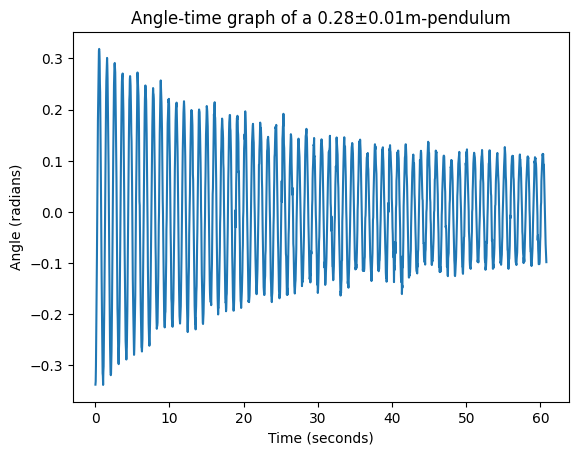

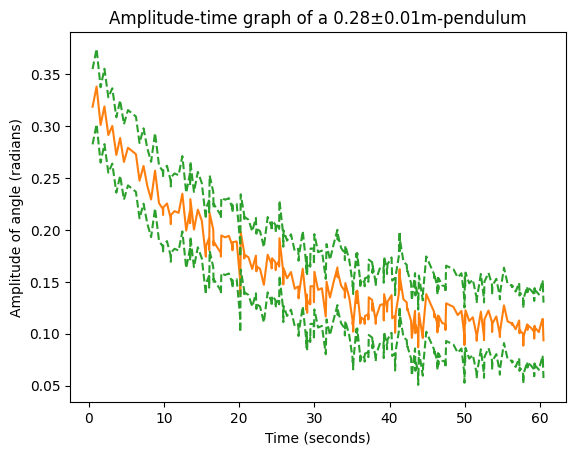

In [3]:
sample_data = data[20]

plt.clf()
plt.title("Angle-time graph of a {:.2f}±{:.2f}m-pendulum".format(
    sample_data['l'], sample_data['l_error']))
plt.xlabel("Time (seconds)")
plt.ylabel("Angle (radians)")
plt.plot(sample_data['t'], sample_data['a'], 'C0')
plt.show()

plt.clf()
plt.title("Amplitude-time graph of a {:.2f}±{:.2f}m-pendulum".format(
    sample_data['l'], sample_data['l_error']))
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude of angle (radians)")
plt.plot(sample_data['t_amp'], sample_data['a_amp'], 'C1')
plt.plot(sample_data['t_amp'], sample_data['a_amp']+sample_data['a_error'], 'C2--')
plt.plot(sample_data['t_amp'], sample_data['a_amp']-sample_data['a_error'], 'C2--')
plt.show()

Intuitively, the amplitude-time graph seems to have a sharper transition than an exponential decay graph. I tried to fit it with different models on Desmos, where the graph can be found here: https://www.desmos.com/calculator/pfdyfmlnkj

Consider to decaying models with value $A_0$ and slope $-A_0\frac{t}{\tau}$ at $t=0$ and value $0$ as $t$ approaches infinity:
 - The exponential decay model $a=A_0\mathrm{e}^{-\frac{t}{\tau}}$ has $R^2=0.8775$. There is a pattern in the residual.
 - The model $a=\frac{A_0}{1+\frac{t}{\tau}}$ has $R^2=0.9298$. There isn't a noticeable pattern in the residual.

It is important to note that I came out with the second model "randomly" without any reference and may need to research for the viability of the second model.

#### Fit the data

Linearly damped harmonic oscillator model

$\theta(t) = \theta_0 \operatorname{e}^{-t/\tau} \cos\left(2\pi\frac{t}{T}+\phi_0\right)$

period, phase guesses: 1.0139507707748951 2.691465972109323
20 [ 0.28452703 48.10044164  1.03090915  2.64803476]
Q factor: 146.6 ± 2.2


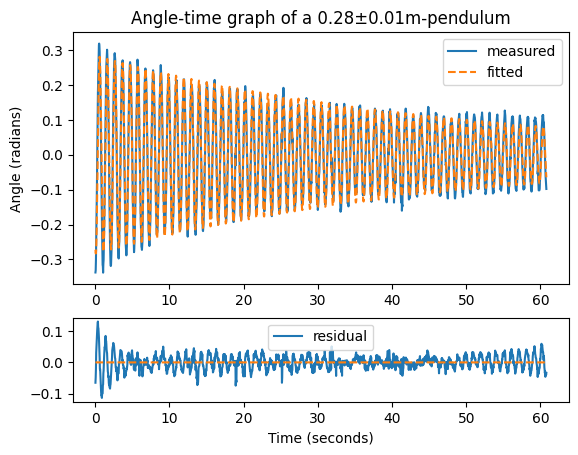

period, phase guesses: 1.2195897419455115 -0.6866440224027887
30 [ 0.31704347 70.2326259   1.22452075 -1.65600879]
Q factor: 180.2 ± 4.2


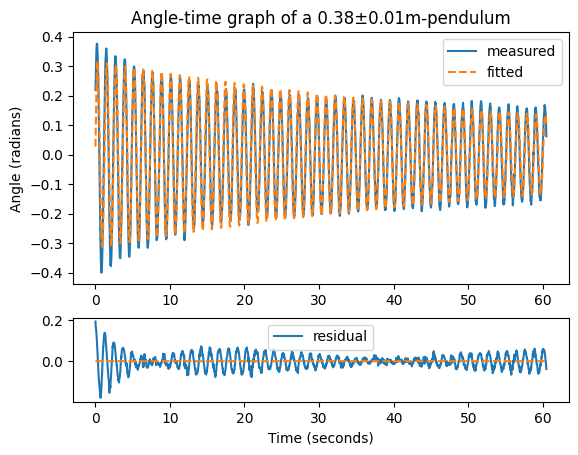

period, phase guesses: 1.37259417482433 -0.007570773496768735
40 [ 0.40685713 88.80452076  1.38341765  1.06091113]
Q factor: 201.7 ± 3.4


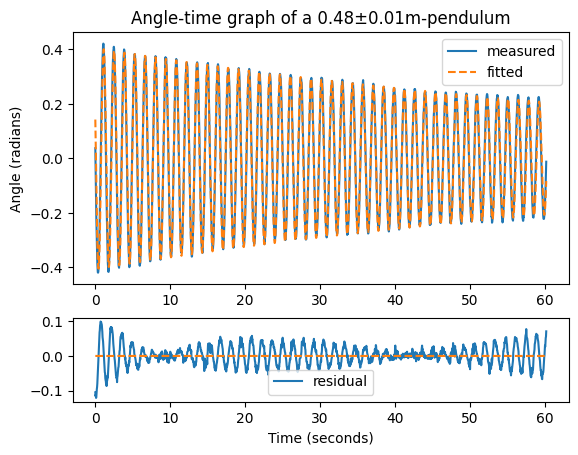

period, phase guesses: 1.4706955208617802 1.072170284023735
50 [  0.4719768  106.72227651   1.52486698   1.47275913]
Q factor: 219.9 ± 4.0


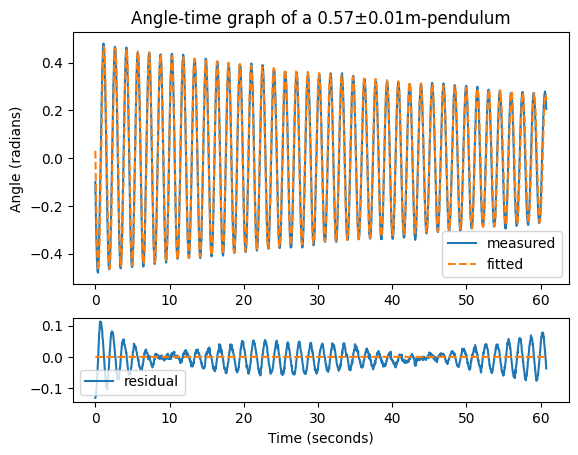

period, phase guesses: 1.6221220903588043 1.6354549680373243
60 [  0.43191813 121.67319521   1.65319969   1.27390781]
Q factor: 231.2 ± 4.4


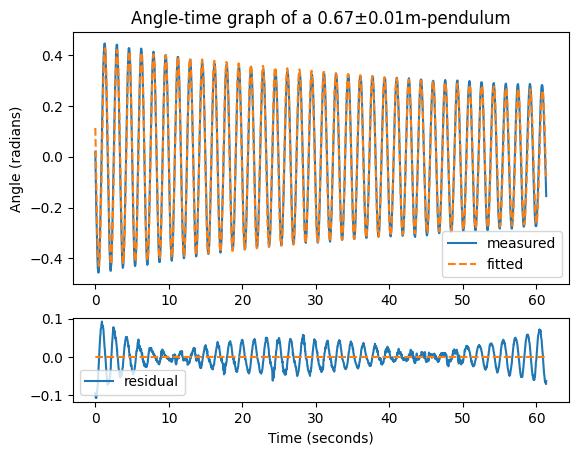

period, phase guesses: 1.6610846453444075 -1.7420554018202692
70 [  0.47078125 119.44899162   1.78147868  -1.59202908]
Q factor: 210.6 ± 3.7


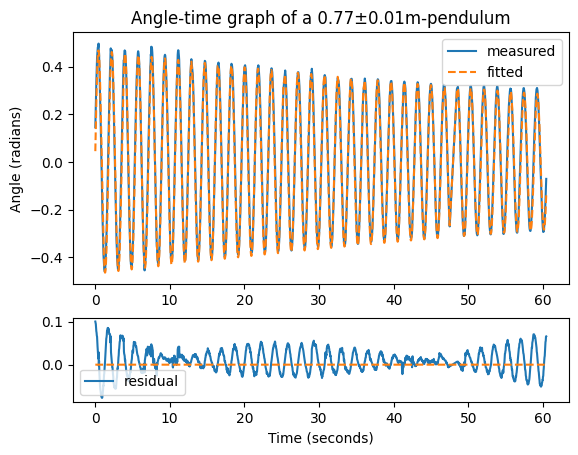

period, phase guesses: 1.8192591686233004 1.1901052802632428
80 [  0.46487505 144.83961271   1.89527552   1.03669967]
Q factor: 240.1 ± 4.3


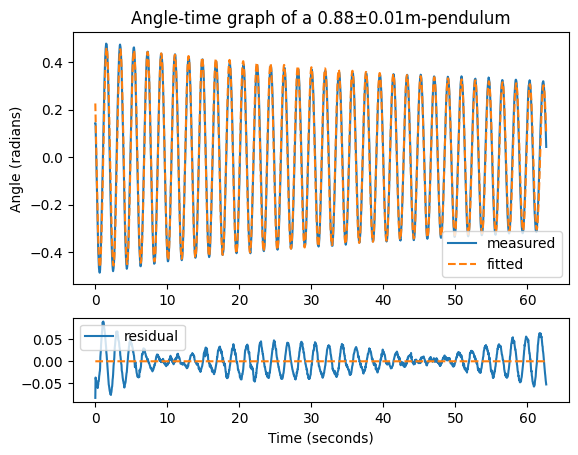

In [4]:
def damped(t, a0, tau):
    return a0 * np.exp(-t/tau)
    # return a0 / (1.0 + t/tau)
    # return a0 / np.sqrt(1.0 + 2.0*t/tau)
    # return a0 / (1.0+0.5*t/tau)**2

def damped_harmonic(t, a0, tau, period, phase):
    a = damped(t, a0, tau)
    return a * np.cos(2.*np.pi*t/period + phase)

def fit_amplitude(t_amp, a_amp, a_error):
    popt, popv = scipy.optimize.curve_fit(
        damped, t_amp, a_amp,
        p0=(0.4, 60.), sigma=a_error*np.ones(len(a)))
    return popt, popv.diagonal()**0.5

def fit_data(t, a, a_error, a0_guess=0.4, tau_guess=60.):
    # guess period and frequency
    tot_t = t[-1]*(len(t)+1)/len(t)
    t_ = tot_t * np.arange(1024)/1024
    a_ = np.interp(t_, t, a)
    af = np.fft.fft(a_)[:len(a_)//2]
    ai = np.argmax(abs(af))
    coes = np.polyfit([ai-1, ai, ai+1], abs(af)[ai-1:ai+2], 2)
    ai = -coes[1]/(2*coes[0])
    period_guess = 2.0 / (tot_t * ai / len(t))
    tc = np.interp(ai, np.arange(len(af)), af)
    phi_guess = np.arctan2(tc.imag, tc.real)
    print("period, phase guesses:", period_guess, phi_guess)
    # regression
    init_guess = (a0_guess, tau_guess, period_guess, phi_guess)
    popt, popv = scipy.optimize.curve_fit(
        damped_harmonic, t, a,
        p0=init_guess, sigma=a_error*np.ones(len(a)))
    return popt, popv.diagonal()**0.5

def plot_angle_time_graph(l, l_error, t, a, params):
    a_pred = damped_harmonic(t, *params)
    residual = a - a_pred

    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

    ax1.set_title("Angle-time graph of a {:.2f}±{:.2f}m-pendulum".format(l, l_error))
    ax2.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Angle (radians)")

    ax1.plot(t, a, '-')
    ax1.plot(t, a_pred, '--')
    ax1.legend(['measured', 'fitted'])

    ax2.plot(t, residual)
    ax2.legend(["residual"])
    ax2.plot(t, np.zeros(len(t)), '--')
    plt.show()

lengths0 = []
lengths_error0 = []
qfactors0 = []
qfactors_error0 = []

for length in LENGTHS:
    sample_data = data[length]
    t, a = sample_data['t'], sample_data['a']
    a_error = sample_data['a_error']
    params, perror = fit_data(t, a, a_error)
    print(length, params)
    a0, tau, period, phase = params
    a0_e, tau_e, period_e, phase_e = perror
    q = np.pi * tau / period
    q_e = q * max(abs(tau_e / tau), abs(period_e / period))
    print("Q factor: {:.1f} ± {:.1f}".format(q, q_e))
    lengths0.append(sample_data['l'])
    lengths_error0.append(sample_data['l_error'])
    qfactors0.append(q)
    qfactors_error0.append(q_e)
    plot_angle_time_graph(
        sample_data['l'], sample_data['l_error'],
        t, a, params)
    # break


Analyze the relationship between Q factor and string length.

[293.2683913    0.53003925] [6.97609002 0.02646649]


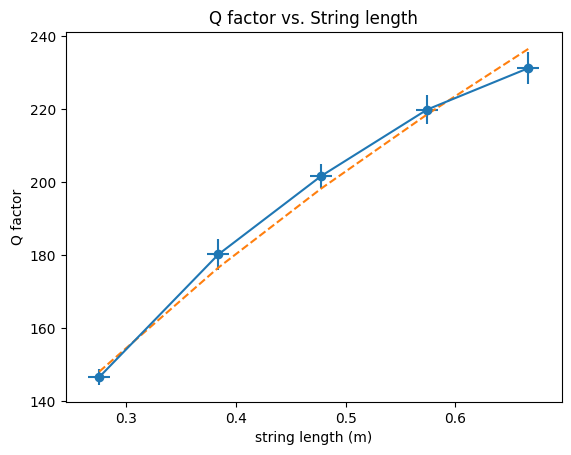

In [5]:
# remove two outliers
indices = [0, 1, 2, 3, 4]
lengths = np.array(lengths0)[indices]
lengths_error = np.array(lengths_error0)[indices]
qfactors = np.array(qfactors0)[indices]
qfactors_error = np.array(qfactors_error0)[indices]

# fit
def power_fun(x, a, k):
    return a * x**k

def log_fun(x, a, b):
    return a + b * np.log(x)

fun = power_fun

init_guess = (250., 0.5)
params, popv = scipy.optimize.curve_fit(
    fun, lengths, qfactors,
    p0=init_guess, sigma=qfactors_error)
print(params, popv.diagonal()**0.5)

# plot Q factor
plt.title("Q factor vs. String length")
plt.xlabel("string length (m)")
plt.ylabel("Q factor")
plt.errorbar(lengths, qfactors,
    xerr=lengths_error, yerr=qfactors_error, fmt="o-")
plt.plot(lengths, fun(lengths, *params), "--")
plt.show()